In [1]:
import getpass
import os
import tarfile
import json
import time
import torch
import s3fs
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck, ResNet18_Weights, ResNet34_Weights, resnet18
from torchvision.datasets import ImageFolder
from data.data_loader import load_cifar10, load_cifar100, load_imagenet, load_prof
from utils.loss_functions import tkd_kdloss

from models_package.models import Teacher, Student


In [2]:
# access_key = getpass.getpass("Enter your access: ")

# secret_key = password = getpass.getpass("Enter your secret: ")

In [3]:
# # Run once to get images onto EC2

# wider_dir = './WIDER'
# if not os.path.exists(wider_dir):
#     os.makedirs(wider_dir)

# # Specify your S3 bucket and file path
# bucket_name = '210bucket'
# s3_file_path = 'wider_attribute_image.tgz'

# # Initialize an S3 filesystem
# s3 = s3fs.S3FileSystem(key=access_key, secret=secret_key)

# # Download the .tgz file from S3
# with s3.open(f"{bucket_name}/{s3_file_path}", 'rb') as s3_file:
#     with tarfile.open(fileobj=s3_file, mode="r:gz") as tar:
#         # Specify the destination directory where you want to store the extracted contents
#         extract_dir = wider_dir # Change this to your desired directory
#         tar.extractall(path=extract_dir)

# print("File downloaded and extracted successfully.")


In [4]:
# # Specify your S3 bucket and directory path
# s3_directory_path = 'wider_attribute_annotation/'

# local_directory = './WIDER/Annotations'  # Change this to your desired directory

# s3_files = s3.ls(f"{bucket_name}/{s3_directory_path}")


# # Create the local directory if it doesn't exist
# os.makedirs(local_directory, exist_ok=True)

# # Download each file from the S3 directory to the local directory
# for s3_file in s3_files:
#     # Get the filename from the S3 file path
#     filename = os.path.basename(s3_file)
    
#     # Download the file to the local directory
#     local_path = os.path.join(local_directory, filename)
#     with s3.open(s3_file, 'rb') as s3_file_obj:
#         with open(local_path, 'wb') as local_file:
#             local_file.write(s3_file_obj.read())

# print("Files downloaded successfully.")


# Load WIDER


In [5]:
# def make_wider(tag, value, data_path):
#     img_path = os.path.join(data_path, "Image")
#     ann_path = os.path.join(data_path, "Annotations")
#     ann_file = os.path.join(ann_path, "wider_attribute_{}.json".format(tag))

#     data = json.load(open(ann_file, "r"))

#     final = []
#     image_list = data['images']
#     for image in image_list:
#         for person in image["targets"]: # iterate over each person
#             tmp = {}
#             tmp['img_path'] = os.path.join(img_path, image['file_name'])
#             tmp['bbox'] = person['bbox']
#             attr = person["attribute"]
#             for i, item in enumerate(attr):
#                 if item == -1:
#                     attr[i] = 0
#                 if item == 0:
#                     attr[i] = value  # pad un-specified samples
#                 if item == 1:
#                     attr[i] = 1
#             tmp["target"] = attr
#             final.append(tmp)

#     json.dump(final, open("data/wider/{}_wider.json".format(tag), "w"))
#     print("data/wider/{}_wider.json".format(tag))

In [6]:
# #run once
# if not os.path.exists("data/wider"):
#     os.makedirs("data/wider")

# # 0 (zero) means negative, we treat un-specified attribute as negative in the trainval set
# make_wider(tag='trainval', value=0, data_path='WIDER') 
# make_wider(tag='test', value=99, data_path='WIDER')

In [37]:
# Hyperparameters
learning_rate = 0.01379 # 0.096779
num_epochs = 20
num_workers = 2
temperature = 4.0
alpha = 0.9
momentum = 0.9
# num_classes = 61
num_classes = 30
step_size = 30
gamma = 0.1
beta = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping

batch_size = 256
num_workers = 4

class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_names = [f"Class {label}" for label in class_labels]

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):
        # Define the original class labels

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                ] 
            )        

        self.anns = []
        self.load_anns()
        self.undersample_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def undersample_anns(self):
        # Shuffle annotations before undersampling
        random.shuffle(self.anns)

        # Count the instances per class
        class_counts = {}
        for ann in self.anns:
            label = self.extract_label(ann['img_path'])  # Assuming this method returns the class label
            class_counts[label] = class_counts.get(label, 0) + 1

        # Find the minimum class count
        min_count = min(class_counts.values())

        # Perform undersampling
        undersampled_anns = []
        current_counts = {label: 0 for label in class_counts}
        for ann in self.anns:
            label = self.extract_label(ann['img_path'])
            if current_counts[label] < min_count:
                undersampled_anns.append(ann)
                current_counts[label] += 1

        # Update the annotations to the undersampled list
        self.anns = undersampled_anns
    
    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(ann["img_path"]).convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            if self.dataset == "wider":
                x, y, w, h = ann['bbox']
                img_area = img.crop([x, y, x+w, y+h])
                img_area = self.augment(img_area)
                img_area = self.transform(img_area)
                
                # Extract label from image path
                img_path = ann['img_path']
                label = self.extract_label(img_path)  # You might need to implement this method
                
                return {
                    "label": label,
                    "target": torch.Tensor(ann['target']),
                    "img": img_area
                }
            
            # Else, add handling for other dataset types
            else:
                # Handle other dataset types here
                pass

        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            return remapped_label
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [10]:
# def count_images_per_class(annotation_files):
#     label_counts = {}

#     for ann_file in annotation_files:
#         with open(ann_file, 'r') as file:
#             annotations = json.load(file)
#             for ann in annotations:
#                 label_str = ann['img_path'].split('/')[1]  # Extract the label part from the file path
#                 label = int(label_str.split("--")[0])  # Extract the numeric part of the label
#                 label_counts[label] = label_counts.get(label, 0) + 1

#     return label_counts


In [11]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [12]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        # Option 1: Return a placeholder tensor (adapt the shape to match your data)
        # return torch.tensor([]), torch.tensor([])
        # Option 2: Raise an exception
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [13]:
train_dataset = DataSet(train_file, augs = ['randomflip'], img_size = 224, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 224, dataset = 'wider')

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=custom_collate)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)



Compose(
    RandomHorizontalFlip(p=0.5)
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
)


In [14]:
def print_dataset_details(dataset):
    unique_labels = set()
    for i in range(len(dataset)):
        item = dataset[i]
        unique_labels.add(item['label'])
    print(f"Dataset - Total Samples: {len(dataset)}, Unique Labels: {unique_labels}")

print_dataset_details(train_dataset)

Dataset - Total Samples: 4320, Unique Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29}


# Start Training Process

In [15]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        # Debug: Check if all predictions are the same
        print("Teacher predictions:", np.unique(teacher_preds))
        print("Student predictions:", np.unique(student_preds))
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    # Debug: Check final label distribution
    print("Label distribution:", np.unique(all_labels, return_counts=True))
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }
    
def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    fig.tight_layout()
    plt.show()

In [16]:
# # Load IdenProf dataset
# train_path = '/home/ubuntu/capstone/W210-Capstone/notebooks/idenprof/train'
# test_path = '/home/ubuntu/capstone/W210-Capstone/notebooks/idenprof/test'
# trainloader, testloader  = load_prof(train_path, test_path, batch_size=batch_size)

In [17]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).to(device)
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = torchvision.models.resnet18(weights=None).to(device)

In [18]:
# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

In [19]:
# #### finding the optimal learning rate
# def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5, lr_range=(1e-4, 1e-1), plot_loss=True):
#     model.train()
#     model.to(device)
#     lr_values = np.logspace(np.log10(lr_range[0]), np.log10(lr_range[1]), num_epochs * len(trainloader))  # Generate learning rates for each batch
#     lr_iter = iter(lr_values)
#     losses = []
#     lrs = []
    
#     for epoch in range(num_epochs):
#         for i, (inputs, labels, annotation) in enumerate(tqdm(trainloader)):
#             lr = next(lr_iter)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = lr  # Set new learning rate
            
#             inputs, labels = inputs.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             losses.append(loss.item())
#             lrs.append(lr)
    
#     # Calculate the derivative of the loss
#     loss_derivative = np.gradient(losses)
    
#     # Find the learning rate corresponding to the minimum derivative (steepest decline)
#     best_lr_index = np.argmin(loss_derivative)
#     best_lr = lrs[best_lr_index]
    
#     if plot_loss:
#         import matplotlib.pyplot as plt
#         plt.figure()
#         plt.plot(lrs, losses)
#         plt.xscale('log')
#         plt.xlabel('Learning Rate')
#         plt.ylabel('Loss')
#         plt.title('Learning Rate Range Test')
#         plt.axvline(x=best_lr, color='red', linestyle='--', label=f'Best LR: {best_lr}')
#         plt.legend()
#         plt.show()
    
#     print(f'Best learning rate: {best_lr}')
#     return best_lr

# ############# input ############## 
# batch_size = 16  #to find the optimal learning rate
# best_lr = train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=3)  
# print(best_lr)

In [20]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.show()

In [21]:
def recall_disparity_loss(outputs, targets, attributes, class_labels):
    """
    Compute the recall disparity loss.
    :param outputs: Tensor of shape (batch_size, num_classes), model's class probabilities or logits.
    :param targets: Tensor of shape (batch_size,), true class indices.
    :param attributes: Tensor of shape (batch_size, num_attributes), binary attributes for each instance.
    :param num_classes: int, number of classes.
    """
    # Ensure we're working with probabilities
    probs = torch.softmax(outputs, dim=1)
    preds = torch.argmax(probs, dim=1)
    # Initialize tensors to store recall for when attributes are present and absent
    recall_when_present = torch.zeros(len(class_labels), attributes.size(1))
    recall_when_absent = torch.zeros(len(class_labels), attributes.size(1))
    # Initialize the disparity matrix
    disparity = torch.zeros(len(class_labels), attributes.size(1))
    for class_idx in range(len(class_labels)):
        for attr_idx in range(attributes.size(1)):
            # Indices of instances with the current class and attribute present/absent
            class_and_attr_present = (targets == class_idx) & (attributes[:, attr_idx] == 1)
            class_and_attr_absent = (targets == class_idx) & (attributes[:, attr_idx] == 0)
            # True positives for current class when attribute is present/absent
            true_positive_present = ((preds == class_idx) & class_and_attr_present).sum().float()
            true_positive_absent = ((preds == class_idx) & class_and_attr_absent).sum().float()
            # Condition positives for current class when attribute is present/absent
            condition_positive_present = class_and_attr_present.sum().float()
            condition_positive_absent = class_and_attr_absent.sum().float()
            # Check if both denominators are non-zero before calculating recall
            if condition_positive_present != 0 and condition_positive_absent != 0:
                recall_when_present[class_idx, attr_idx] = true_positive_present / condition_positive_present
                recall_when_absent[class_idx, attr_idx] = true_positive_absent / condition_positive_absent
                # Disparity is the absolute difference between recall when attribute is present and when it's absent
                disparity[class_idx, attr_idx] = (recall_when_present[class_idx, attr_idx] - recall_when_absent[class_idx, attr_idx]).abs()
    # Compute the average disparity
    average_disparity = disparity.mean().item()
    return average_disparity

In [22]:
# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=1, patience=5):

    model.train()
    model.to(device)
    best_train_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            if index % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {index + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)
        
        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            # checkpoint
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint.pth')

        else:
            patience_counter += 1

        if patience_counter >= patience:
            print('Early stopping')
            break

        scheduler.step()

    print("Finished Training Teacher")
    plot_loss_curve(epoch_losses)
    return epoch_losses


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs, patience=5):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    best_train_loss = float('inf')
    patience_counter = 0
    student_epoch_losses = []
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        epoch_loss = 0.0
        num_batches = 0
        epoch_disparity = 0.0
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            annot = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Ensure this returns a scalar
            
            disparity = recall_disparity_loss(student_outputs, labels, annot, class_labels)
            # disparity = recall_difference[0]
            # recall_with = recall_difference[1]
            # recall_without = recall_difference[2]
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
            # if disparity.ndim != 0:
            #     disparity = disparity.sum()
            
            # Combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss + beta * disparity
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
            epoch_disparity += disparity
    
            if index % 100 == 99:
                print(f"[{epoch + 1}, {index + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        
        epoch_loss /= num_batches
        student_epoch_losses.append(epoch_loss)

        print(f'*******Epoch {epoch}: disparity - {epoch_disparity/num_batches}******')

        # Check for early stopping
        if epoch_loss < best_train_loss:
            best_train_loss = epoch_loss
            patience_counter = 0 
            torch.save(student.state_dict(), f'student_model_weights_ckd_prof_checkpoint.pth')
            torch.save(student, f'student_model_ckd_prof_checkpoint.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  

        scheduler.step() 

    print("Finished Training Student")
    plot_loss_curve(student_epoch_losses)
    return student_epoch_losses


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:22<00:00,  1.35s/it]


Finished Training Teacher


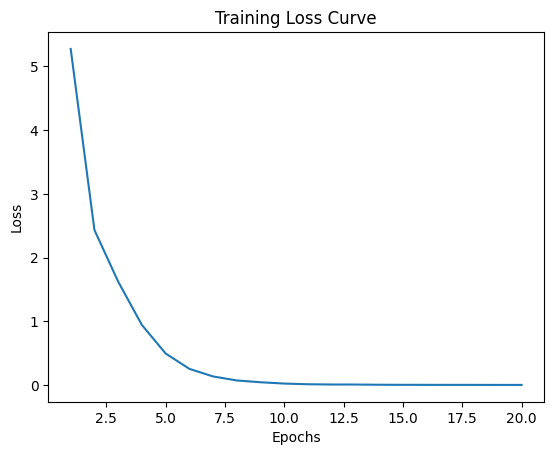

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.44s/it]


*******Epoch 0: disparity - 0.012407205629107706******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.44s/it]


*******Epoch 1: disparity - 0.028623715536121058******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.44s/it]


*******Epoch 2: disparity - 0.05266362625886412******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.44s/it]


*******Epoch 3: disparity - 0.06870200791779686******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.45s/it]


*******Epoch 4: disparity - 0.07268739579355016******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.42s/it]


*******Epoch 5: disparity - 0.07118616318878006******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.43s/it]


*******Epoch 6: disparity - 0.08873954086619265******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.43s/it]


*******Epoch 7: disparity - 0.09709194390212789******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.44s/it]


*******Epoch 8: disparity - 0.10031481656958074******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.43s/it]


*******Epoch 9: disparity - 0.09977022689931533******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.42s/it]


*******Epoch 10: disparity - 0.10733260871732936******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.44s/it]


*******Epoch 11: disparity - 0.10491620836889043******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.45s/it]


*******Epoch 12: disparity - 0.11394036561250687******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.45s/it]


*******Epoch 13: disparity - 0.1063354615779484******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.45s/it]


*******Epoch 14: disparity - 0.12493037783047732******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.45s/it]


*******Epoch 15: disparity - 0.12340639750747119******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.44s/it]


*******Epoch 16: disparity - 0.1294431226218448******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.43s/it]


*******Epoch 17: disparity - 0.1284862708519487******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.43s/it]


*******Epoch 18: disparity - 0.13893449920065262******


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:24<00:00,  1.44s/it]


*******Epoch 19: disparity - 0.13975658837486715******
Finished Training Student


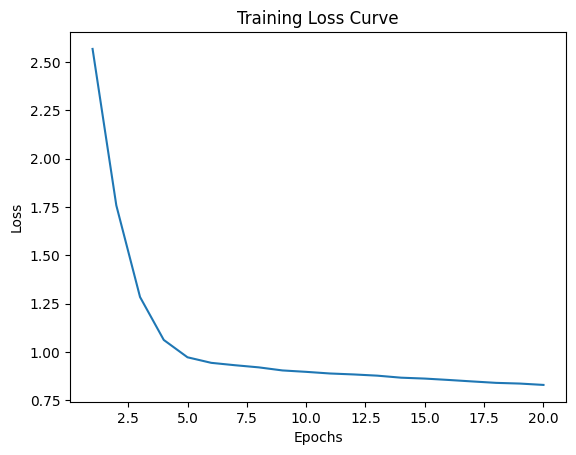

[2.567330178092508,
 1.7580878033357508,
 1.2839016143013449,
 1.061823027975419,
 0.9721139669418335,
 0.9434108208207523,
 0.9310699420816758,
 0.9200202892808353,
 0.9041005057447097,
 0.8968032668618595,
 0.8883352174478418,
 0.8833828217842999,
 0.8770806228413301,
 0.8666036619859583,
 0.8619752105544595,
 0.8548717007917517,
 0.8471657528596765,
 0.839834030936746,
 0.8361984035548042,
 0.8291620682267582]

In [23]:
# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation_disparity(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


In [24]:
###################### Testing 1 ######################
# Save the student and teacher model weights and architecture
# torch.save(student_model.state_dict(), 'student_model_weights_ckd_prof.pth')
# torch.save(student_model, 'student_model_ckd_prof.pth')
# print('student weights and architecture saved and exported')

# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_prof.pth')
# torch.save(teacher_model, 'teacher_model_ckd_prof.pth')
# print('teacher weights and architecture saved and exported')

Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  5  6  7  9 11 12 13 14 15 16 17 19 20 21 22 23 24 25 26 27
 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28

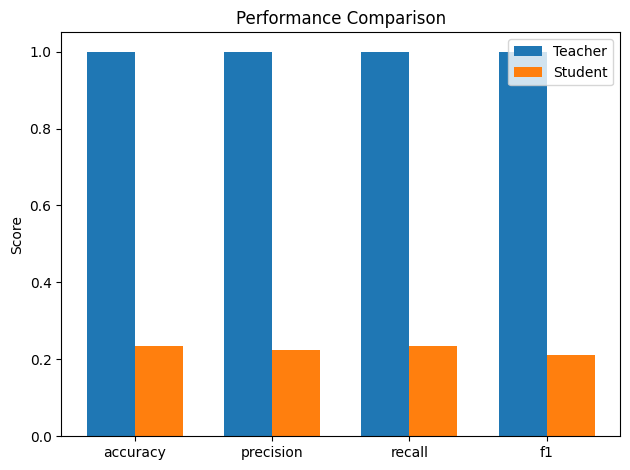

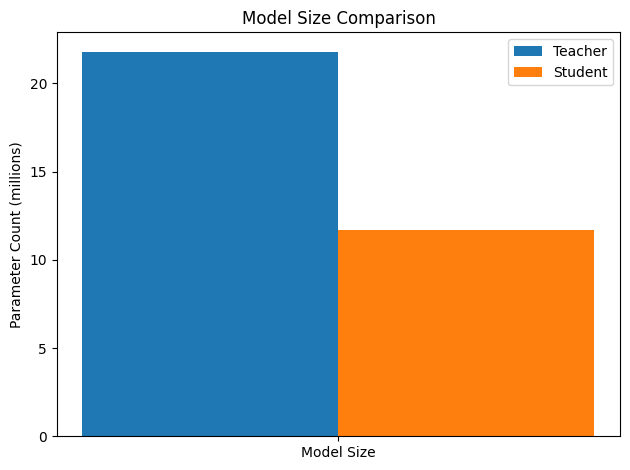

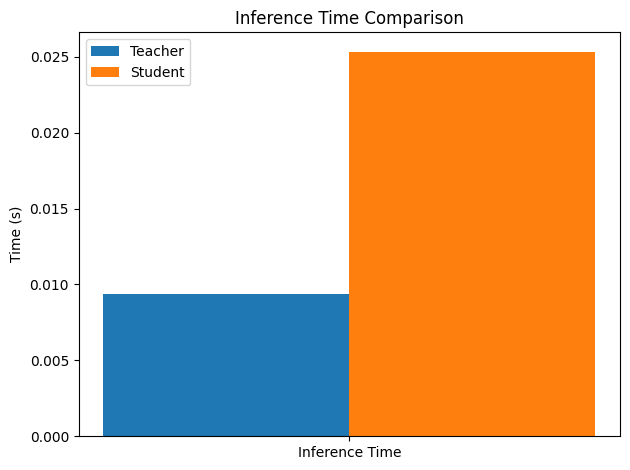

In [25]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']

# Ensure to access the 'metrics' key first before the individual metric keys
teacher_performance_values = [performance_metrics['metrics'][metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics['metrics'][metric][1] for metric in performance_labels]


# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [26]:
performance_metrics

{'metrics': {'accuracy': (1.0, 0.23402777777777778),
  'precision': (1.0, 0.22504077866988825),
  'recall': (1.0, 0.23402777777777778),
  'f1': (1.0, 0.21047698513069543)},
 'all_labels': array([28,  7, 28, ..., 26, 12, 19]),
 'all_teacher_preds': array([28,  7, 28, ..., 26, 12, 19]),
 'all_student_preds': array([28, 16, 28, ..., 25, 12,  2])}

Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27

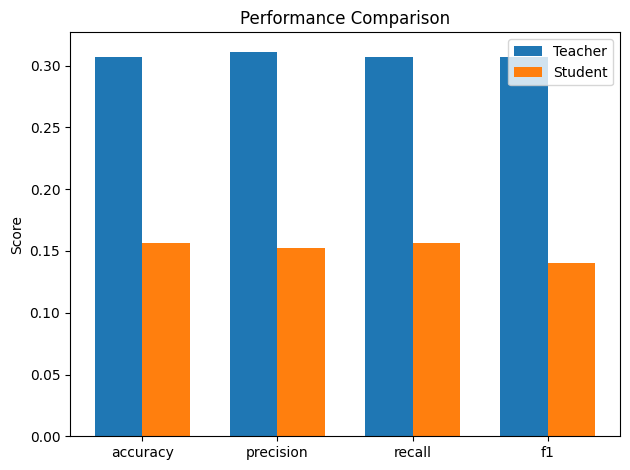

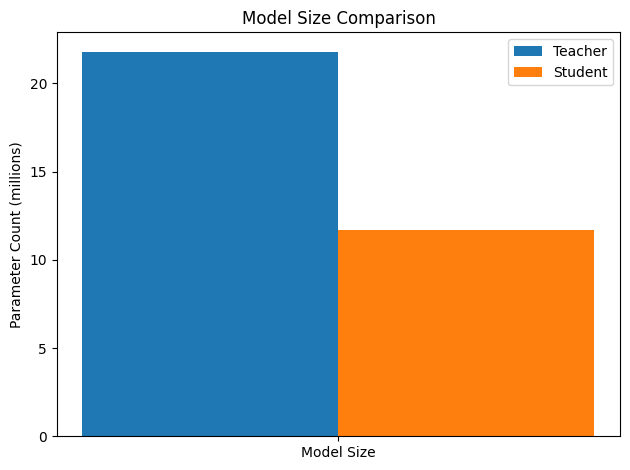

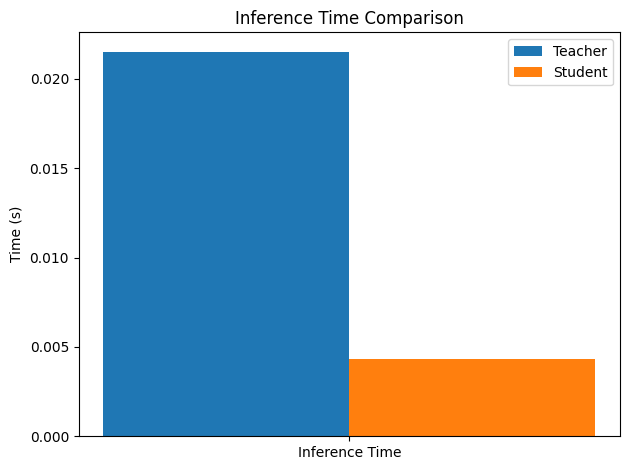

In [27]:
# teacher_model = torchvision.models.resnet34(weights=None)

# weights_path = 'teacher_model_weights_ckd_prof.pth'

# teacher_model.load_state_dict(torch.load(weights_path))

# student_model = torchvision.models.resnet18(weights=None)

# weights_path = 'student_model_weights_ckd_prof.pth'

# student_model.load_state_dict(torch.load(weights_path))

# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']

# Ensure to access the 'metrics' key first before the individual metric keys
teacher_performance_values = [performance_metrics['metrics'][metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics['metrics'][metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')

In [28]:
# def evaluate_disparity(model, dataloader, num_classes, device):
#     model.eval()
#     initialized = False

#     with torch.no_grad():
#         for batch in dataloader:
#             inputs = batch['img'].to(device)
#             targets = batch['label'].to(device)
#             attributes = batch['target'].to(device)

#             # Initialize sums and counts after attributes is defined and on the same device
#             if not initialized:
#                 disparity_sums = torch.zeros(num_classes, attributes.size(1), device=device)
#                 counts = torch.zeros(num_classes, attributes.size(1), device=device)
#                 initialized = True

#             outputs = model(inputs)
#             preds = torch.argmax(outputs, dim=1)

#             for class_idx in class_labels:
#                 for attr_idx in range(attributes.size(1)):
#                     condition_present = (attributes[:, attr_idx] == 1) & (targets == class_idx)
#                     condition_absent = (attributes[:, attr_idx] == 0) & (targets == class_idx)

#                     recall_present = calculate_recall(preds, targets, condition_present)
#                     recall_absent = calculate_recall(preds, targets, condition_absent)

#                     disparity = abs(recall_present - recall_absent)
#                     disparity_sums[class_idx][attr_idx] += disparity
#                     counts[class_idx][attr_idx] += 1

#     average_disparities = disparity_sums / counts
#     for class_idx in class_labels:
#         for attr_idx in range(attributes.size(1)):
#             print(f"Class: {class_idx}, Attr: {attr_idx}, Avg Disparity: {average_disparities[class_idx][attr_idx]}")

#     return average_disparities


In [29]:
# disparity = evaluate_disparity(student_model, testloader, num_classes=num_classes, device=device)
# # print(f'Average recall disparity across all attributes and classes: {disparity}')


In [34]:
def calculate_recall(preds, targets, condition):
    """
    Calculate recall for a given condition in a multi-class setting.

    :param preds: Predicted classes.
    :param targets: True classes.
    :param condition: Boolean tensor indicating the condition (subset) for which to calculate recall.
    :return: Recall value.
    """
    if condition.sum() == 0:  # No samples meet the condition
        return 0.0

    filtered_preds = preds[condition]
    filtered_targets = targets[condition]

    true_positive = (filtered_preds == filtered_targets).sum().float()
    condition_positive = filtered_targets.size(0)

    recall = true_positive / condition_positive if condition_positive > 0 else 0.0
    return recall

# def calculate_weighted_disparity(disparities, counts):
#     """
#     Calculate weighted disparity based on the presence of class-attribute pairs.
#     """
#     total_disparity = sum(disparities)
#     total_count = sum(counts)

#     if total_count == 0:
#         return 0.0  # Avoid division by zero

#     weighted_disparity = total_disparity / total_count
#     return weighted_disparity

def evaluate_disparity(model, dataloader, class_labels, device):
    """
    Evaluate the disparity on the test data with weighted consideration.
    """
    model.eval()
    total_disparity = []
    total_counts = []

    with torch.no_grad():
        for batch in dataloader:
            inputs = batch['img'].to(device)
            targets = batch['label'].to(device)
            attributes = batch['target'].to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            for class_idx in class_labels:
                for attr_idx in range(attributes.size(1)):
                    condition_present = (attributes[:, attr_idx] == 1) & (targets == class_idx)
                    condition_absent = (attributes[:, attr_idx] == 0) & (targets == class_idx)

                    if condition_present.sum() + condition_absent.sum() > 1:
                        recall_present = calculate_recall(preds, targets, condition_present)
                        recall_absent = calculate_recall(preds, targets, condition_absent)

                        disparity = abs(recall_present - recall_absent)
                        count = condition_present.sum() + condition_absent.sum()
                        total_disparity.append(disparity * count.item())
                        total_counts.append(count.item())
 
    return sum(total_disparity) / sum(total_counts)


In [35]:
disparity = evaluate_disparity(student_model, testloader, class_labels=class_labels, device=device)

# Calculate the average recall disparity
average_disparity = disparity.mean()
print(f'Average recall disparity across all attributes and classes: {average_disparity}')

Average recall disparity across all attributes and classes: 0.1286419779062271


In [40]:
class_labels = list(range(30))
class_names = [f"Class {label}" for label in class_labels]
class_names

['Class 0',
 'Class 1',
 'Class 2',
 'Class 3',
 'Class 4',
 'Class 5',
 'Class 6',
 'Class 7',
 'Class 8',
 'Class 9',
 'Class 10',
 'Class 11',
 'Class 12',
 'Class 13',
 'Class 14',
 'Class 15',
 'Class 16',
 'Class 17',
 'Class 18',
 'Class 19',
 'Class 20',
 'Class 21',
 'Class 22',
 'Class 23',
 'Class 24',
 'Class 25',
 'Class 26',
 'Class 27',
 'Class 28',
 'Class 29']

Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25
 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Student predictions: [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Teacher predictions: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27

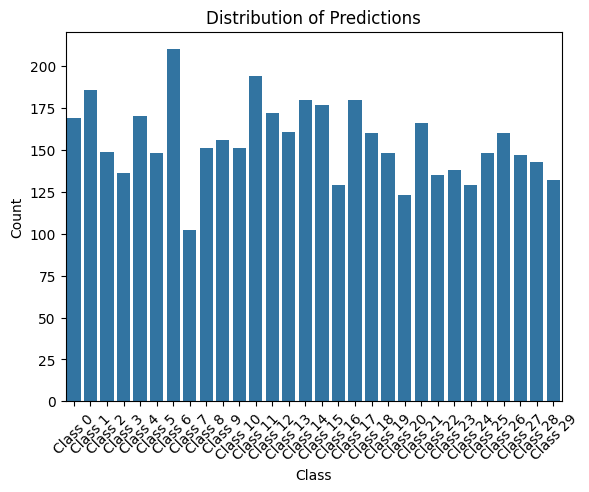

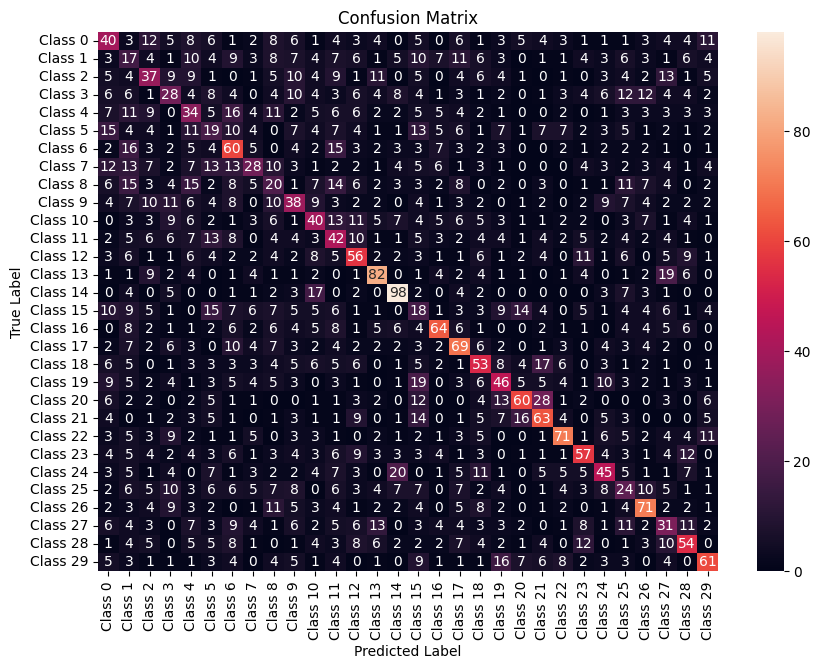

              precision    recall  f1-score   support

     Class 0       0.24      0.26      0.25       155
     Class 1       0.09      0.11      0.10       155
     Class 2       0.25      0.24      0.24       155
     Class 3       0.21      0.18      0.19       155
     Class 4       0.20      0.22      0.21       155
     Class 5       0.13      0.12      0.13       155
     Class 6       0.29      0.39      0.33       155
     Class 7       0.27      0.18      0.22       155
     Class 8       0.13      0.13      0.13       155
     Class 9       0.24      0.25      0.24       155
    Class 10       0.26      0.26      0.26       155
    Class 11       0.22      0.27      0.24       155
    Class 12       0.33      0.36      0.34       155
    Class 13       0.51      0.53      0.52       155
    Class 14       0.54      0.63      0.59       155
    Class 15       0.10      0.12      0.11       155
    Class 16       0.50      0.41      0.45       155
    Class 17       0.38    

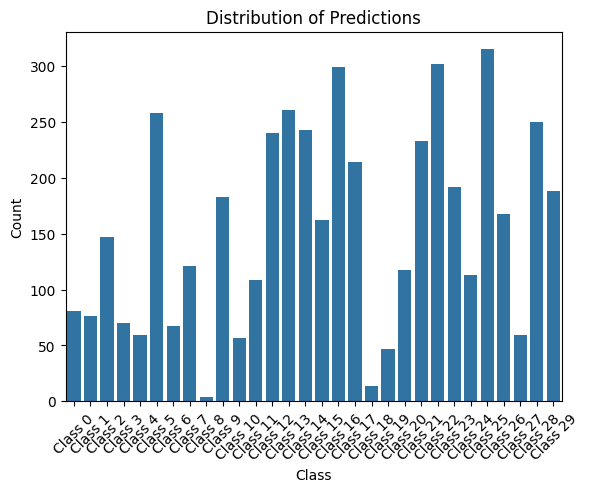

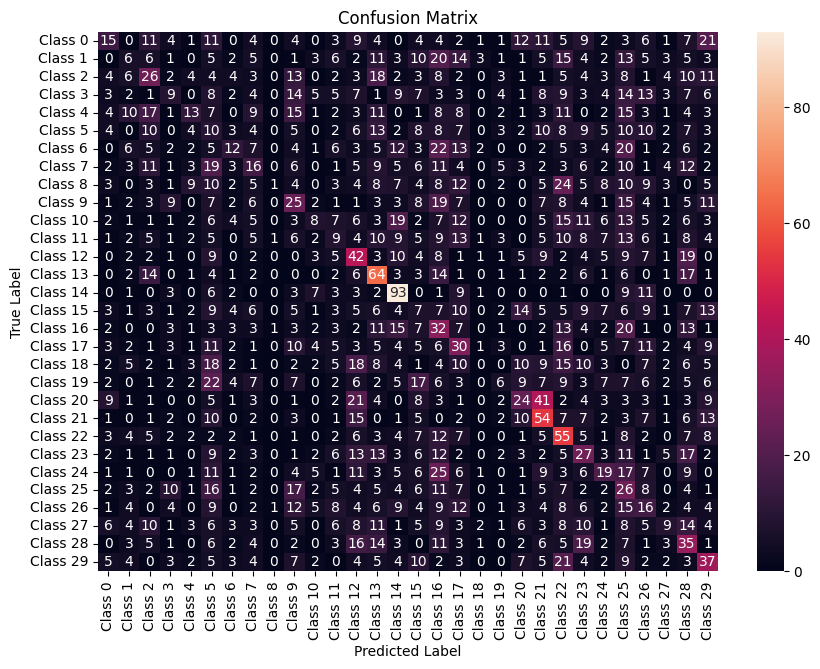

              precision    recall  f1-score   support

     Class 0       0.19      0.10      0.13       155
     Class 1       0.08      0.04      0.05       155
     Class 2       0.18      0.17      0.17       155
     Class 3       0.13      0.06      0.08       155
     Class 4       0.22      0.08      0.12       155
     Class 5       0.04      0.06      0.05       155
     Class 6       0.18      0.08      0.11       155
     Class 7       0.13      0.10      0.12       155
     Class 8       0.25      0.01      0.01       155
     Class 9       0.14      0.16      0.15       155
    Class 10       0.14      0.05      0.08       155
    Class 11       0.08      0.06      0.07       155
    Class 12       0.17      0.27      0.21       155
    Class 13       0.25      0.41      0.31       155
    Class 14       0.38      0.60      0.47       155
    Class 15       0.04      0.05      0.04       155
    Class 16       0.11      0.21      0.14       155
    Class 17       0.14    

In [41]:
def plot_prediction_distribution_and_confusion_matrix(labels, preds, class_names):
    # Plotting the distribution of predictions
    sns.countplot(x=preds)
    plt.title('Distribution of Predictions')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.show()

    # Computing the confusion matrix
    cm = confusion_matrix(labels, preds)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='g')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Print classification report for detailed metrics
    print(classification_report(labels, preds, target_names=class_names, zero_division=0))

performance_metrics_teacher = compare_performance_metrics(teacher_model, student_model, testloader)
all_labels = performance_metrics_teacher['all_labels']
all_teacher_preds = performance_metrics_teacher['all_teacher_preds']
all_student_preds = performance_metrics_teacher['all_student_preds']

# For the Teacher Model
plot_prediction_distribution_and_confusion_matrix(all_labels, all_teacher_preds, class_names)

# For the Student Model
plot_prediction_distribution_and_confusion_matrix(all_labels, all_student_preds, class_names)
